In [54]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from typing import List

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
with open("resources/cards.json", "r", encoding="utf-8") as f:
    data = json.loads(f.read())

data_df = pd.DataFrame(data)
data_df.head()

,cardClass,dbfId,health,heroPowerDbfId,id,name,set,type,attack,cost,...,battlegroundsHero,isBattlegroundsBuddy,battlegroundsSkinParentId,battlegroundsDarkmoonPrizeTurn,classes,puzzleType,multiClassGroup,isMiniSet,mercenariesAbilityCooldown,questReward
0,DEMONHUNTER,91661,30.0,60224.0,AIBot_DemonHunterTrainee_001_hb,DemonHunter Trainee,THE_SUNKEN_CITY,HERO,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DRUID,91662,30.0,1123.0,AIBot_DruidTrainee_002_hb,Druid Trainee,THE_SUNKEN_CITY,HERO,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HUNTER,91663,30.0,229.0,AIBot_HunterTrainee_003_hb,Hunter Trainee,THE_SUNKEN_CITY,HERO,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MAGE,91664,30.0,807.0,AIBot_MageTrainee_004_hb,Mage Trainee,THE_SUNKEN_CITY,HERO,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PALADIN,91665,30.0,472.0,AIBot_PaladinTrainee_005_hb,Paladin Trainee,THE_SUNKEN_CITY,HERO,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
data_df["type"].value_counts()

MINION                       7932
ENCHANTMENT                  4833
SPELL                        4832
LETTUCE_ABILITY              4465
HERO                         2030
HERO_POWER                   1666
WEAPON                        383
BATTLEGROUND_QUEST_REWARD      45
LOCATION                       23
GAME_MODE_BUTTON                8
MOVE_MINION_HOVER_TARGET        3
BATTLEGROUND_HERO_BUDDY         1
Name: type, dtype: int64

In [4]:
minions_df = data_df.loc[data_df['type'] == "MINION", :]

In [5]:
minions_df.columns

Index(['cardClass', 'dbfId', 'health', 'heroPowerDbfId', 'id', 'name', 'set',
       'type', 'attack', 'cost', 'faction', 'rarity', 'artist', 'collectible',
       'flavor', 'spellSchool', 'text', 'mechanics', 'race', 'races',
       'referencedTags', 'elite', 'targetingArrowText', 'durability',
       'overload', 'spellDamage', 'battlegroundsPremiumDbfId', 'techLevel',
       'collectionText', 'hasDiamondSkin', 'howToEarnGolden', 'armor',
       'howToEarn', 'hideCost', 'hideStats', 'mercenariesRole',
       'battlegroundsNormalDbfId', 'isBattlegroundsPoolMinion',
       'battlegroundsBuddyDbfId', 'battlegroundsHero', 'isBattlegroundsBuddy',
       'battlegroundsSkinParentId', 'battlegroundsDarkmoonPrizeTurn',
       'classes', 'puzzleType', 'multiClassGroup', 'isMiniSet',
       'mercenariesAbilityCooldown', 'questReward'],
      dtype='object')

In [6]:
cols_to_use = [
    #"cardClass", 
    "health", 
    #"set", 
    "attack",
    "cost", "rarity", "elite", "overload", 
    "spellDamage", "techLevel", "armor",
    "hideCost", "mechanics", "races"
]

In [7]:
clean_minions_df = minions_df.loc[minions_df["mercenariesRole"].isna(), :]
clean_minions_df = clean_minions_df[cols_to_use]
# clean_minions_df.drop(["mercenariesRole", "type", "name", "text", "race"], axis=1, inplace=True)

# Dealing with NaN
clean_minions_df.fillna({col: 0 for col in ["overload", "spellDamage", "techLevel", "armor"]}, inplace=True)
clean_minions_df.fillna({col: False for col in ["elite", "hideCost"]}, inplace=True)
clean_minions_df.fillna({"rarity": "NONE"}, inplace=True)

# Creating dummy variables
mechs_temp = clean_minions_df["mechanics"].str.join("|").str.get_dummies()
mechs_temp = mechs_temp.add_prefix("mech_")
races_temp = clean_minions_df["races"].str.join("|").str.get_dummies()
races_temp = races_temp.add_prefix("race_")
clean_minions_df = pd.concat([clean_minions_df, mechs_temp, races_temp], axis=1)
clean_minions_df.drop(["mechanics", "races"], axis=1, inplace=True)

# Encoding attributes with labels
rarity_to_int = {'NONE': 0, 'FREE': 1, 'COMMON': 2, 'RARE': 3, 'EPIC': 4, 'LEGENDARY': 5}
clean_minions_df["rarity"] = clean_minions_df["rarity"].replace(rarity_to_int)

In [8]:
clean_minions_df

,health,attack,cost,rarity,elite,overload,spellDamage,techLevel,armor,hideCost,...,race_NIGHTELF,race_OLDGOD,race_ORC,race_PIRATE,race_QUILBOAR,race_TAUREN,race_TOTEM,race_TROLL,race_UNDEAD,race_WORGEN
10,0.0,0.0,0.0,5,False,0.0,0.0,0.0,0.0,False,...,0,0,0,0,0,0,0,0,0,0
13,2.0,3.0,2.0,3,False,0.0,0.0,0.0,0.0,False,...,0,0,0,0,0,0,0,0,1,0
16,2.0,4.0,3.0,0,False,0.0,0.0,0.0,0.0,False,...,0,0,0,0,0,0,0,0,0,0
17,5.0,3.0,4.0,2,False,0.0,0.0,0.0,0.0,False,...,0,0,0,0,0,0,0,0,0,0
19,4.0,3.0,3.0,2,False,0.0,0.0,0.0,0.0,False,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26251,3.0,2.0,2.0,2,False,0.0,0.0,0.0,0.0,False,...,0,0,0,0,0,0,0,0,0,0
26253,4.0,1.0,2.0,2,False,0.0,0.0,0.0,0.0,False,...,0,0,0,0,0,0,0,0,0,0
26255,3.0,1.0,1.0,3,False,0.0,0.0,0.0,0.0,False,...,0,0,0,0,0,0,0,0,0,0
26257,9.0,9.0,9.0,3,False,0.0,0.0,0.0,0.0,False,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:xlabel='cost', ylabel='Count'>

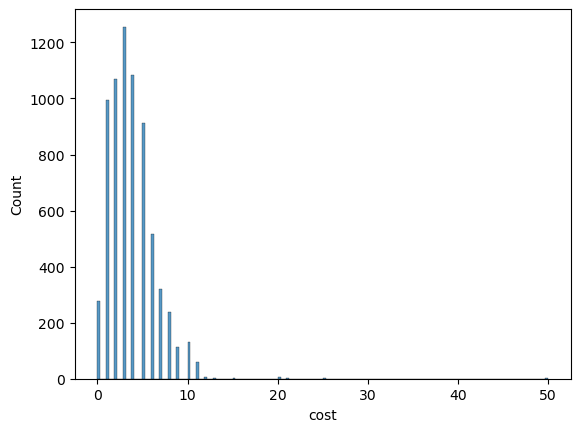

In [9]:
sns.histplot(clean_minions_df, x="cost")

<AxesSubplot:>

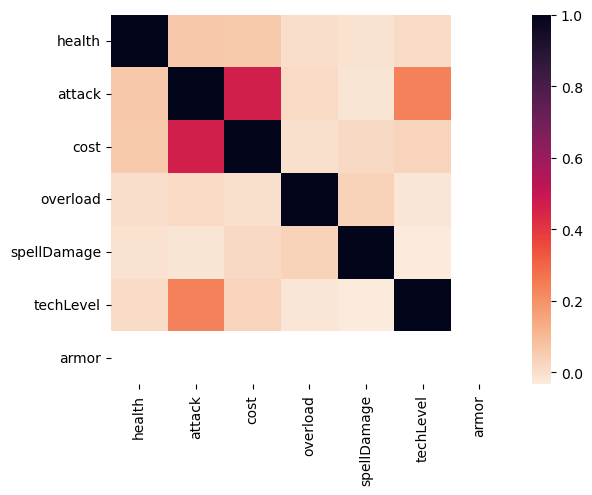

In [31]:
sns.heatmap(clean_minions_df[["health", "attack", "cost", "overload", "spellDamage", "techLevel", "armor"]].corr(), cmap="rocket_r")

In [11]:
def split_dataset(df: pd.DataFrame, test_size=0.3, shuffle=False, seed=42):
    np.random.seed(seed)
    train_df, test_df = train_test_split(df, test_size=test_size, shuffle=shuffle)
    return train_df, test_df

In [12]:
SEED = 42

target = "cost"
features = [col for col in clean_minions_df.columns if col != target]

train_df, test_df = split_dataset(clean_minions_df, test_size=0.2, shuffle=True, seed=SEED)
print(f"Size of training set: {len(train_df)}")
print(f"Size of testing set: {len(test_df)}")

Size of training set: 5593
Size of testing set: 1399


In [13]:
dtr = DecisionTreeRegressor()
linear = LinearRegression()
forest = RandomForestRegressor()

models = [dtr, linear, forest]

In [14]:
def evaluate_models(models: list, train_df: pd.DataFrame, test_df: pd.DataFrame, features, target, metric=mean_absolute_error):
    results = []

    for model in models:
        model.fit(train_df[features], train_df[target])

        train_pred = model.predict(train_df[features])
        test_pred = model.predict(test_df[features])

        train_eval = metric(train_df[target], train_pred)
        test_eval = metric(test_df[target], test_pred)

        results.append([model.__class__.__name__, train_eval, test_eval])

    results = pd.DataFrame(results, columns=["Model", "Train_eval", "Test_eval"])
    return results

In [15]:
evaluate_models(models, train_df, test_df, features, target, mean_absolute_error)

,Model,Train_eval,Test_eval
0,DecisionTreeRegressor,0.233365,0.924916
1,LinearRegression,1.368822,1.425116
2,RandomForestRegressor,0.471863,0.872624


In [16]:
kek = pd.DataFrame([])
kek["Feature"] = forest.feature_names_in_
kek["Importance"] = forest.feature_importances_

In [17]:
kek.sort_values(by="Importance", ascending=False).head(20)

,Feature,Importance
1,attack,0.325070
0,health,0.206668
3,elite,0.072735
2,rarity,0.070687
6,techLevel,0.050275
69,mech_UNTOUCHABLE,0.045777
68,mech_TRIGGER_VISUAL,0.040476
72,race_BEAST,0.012806
14,mech_BATTLECRY,0.012233
65,mech_TAUNT,0.011419


## Training Regressor With Just Embeddings of Text on Cards

In [18]:
from sentence_transformers import SentenceTransformer

embed_model = SentenceTransformer('all-MiniLM-L6-v2')
EMBEDDINGS_SIZE = 384

# embed_model = SentenceTransformer('all-mpnet-base-v2')
# EMBEDDINGS_SIZE = 768

In [19]:
embeds = embed_model.encode(minions_df.loc[:, "text"].dropna().to_list())
embeds

array([[-0.05070474,  0.10858292, -0.0080826 , ..., -0.00501248,
        -0.04726277, -0.01907052],
       [-0.03393447,  0.08670289, -0.07934991, ...,  0.08266596,
        -0.01603744, -0.00352595],
       [-0.06836951,  0.01028109, -0.03627139, ...,  0.02279051,
         0.00371011,  0.04035719],
       ...,
       [-0.03869144,  0.10916521, -0.08048223, ..., -0.01752804,
        -0.02942967,  0.00538955],
       [-0.0009386 ,  0.08756767,  0.01115188, ...,  0.08248911,
        -0.02086502,  0.04336291],
       [ 0.00983532,  0.03476483,  0.01820617, ..., -0.06154502,
         0.03598524,  0.04474059]], dtype=float32)

In [20]:
embed_df = pd.DataFrame(
    embeds, 
    index=minions_df.index[~minions_df["text"].isna()], 
    columns=[f"embed_{i}" for i in range(EMBEDDINGS_SIZE)]
)
embed_df["cost"] = minions_df.loc[embed_df.index, "cost"]
embed_df

,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,embed_9,...,embed_375,embed_376,embed_377,embed_378,embed_379,embed_380,embed_381,embed_382,embed_383,cost
13,-0.050705,0.108583,-0.008083,0.057816,0.010895,-0.054782,0.074022,0.015867,0.025675,-0.002483,...,0.059304,-0.015086,0.028698,0.022828,0.001802,0.016573,-0.005012,-0.047263,-0.019071,2.0
16,-0.033934,0.086703,-0.079350,0.014505,0.012004,0.012173,0.069864,-0.000684,0.061993,0.048430,...,0.019696,0.036998,0.017900,-0.019955,0.049327,0.163510,0.082666,-0.016037,-0.003526,3.0
17,-0.068370,0.010281,-0.036271,0.021027,-0.058641,0.054810,0.073185,0.020956,-0.019111,-0.002764,...,0.015642,0.007485,0.068974,0.032659,0.003745,0.126064,0.022791,0.003710,0.040357,4.0
19,-0.074030,0.013283,-0.049839,-0.018054,-0.097390,0.039386,0.098526,-0.036784,-0.004433,0.001438,...,0.052185,0.055281,0.048231,0.076931,0.059166,-0.042431,0.059675,-0.066042,0.031076,3.0
20,-0.044500,0.079646,-0.092036,0.035489,-0.049270,-0.000402,0.051420,-0.034924,0.031277,-0.009493,...,0.084217,0.006272,-0.031067,-0.033810,-0.012999,0.054396,0.012458,-0.022060,-0.055961,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26251,-0.026952,0.138454,-0.039779,0.046839,0.032600,-0.066374,0.037719,0.036555,0.055622,0.033781,...,0.037149,-0.015021,0.046935,-0.056297,0.018722,0.050699,-0.031542,-0.058528,-0.026149,2.0
26253,-0.023494,0.037535,-0.017948,0.036844,0.024912,0.039165,0.062875,-0.030851,0.028518,-0.022754,...,0.056505,-0.057315,0.031741,-0.033845,0.040271,-0.014978,0.018475,-0.021164,0.049160,2.0
26255,-0.038691,0.109165,-0.080482,-0.057363,-0.056976,0.070400,0.057822,-0.031644,-0.071969,0.006942,...,0.013771,0.072707,-0.010307,0.095671,0.045231,-0.056539,-0.017528,-0.029430,0.005390,1.0
26257,-0.000939,0.087568,0.011152,-0.017362,0.033309,0.024854,0.098753,0.073590,-0.038297,-0.029250,...,0.055907,0.031149,-0.043387,0.018832,0.055359,0.032653,0.082489,-0.020865,0.043363,9.0


In [21]:
target = "cost"
features = embed_df.columns.drop(target)

train_df, test_df = split_dataset(embed_df, test_size=0.2, shuffle=True, seed=SEED)
print(f"Size of training set: {len(train_df)}")
print(f"Size of testing set: {len(test_df)}")

Size of training set: 5373
Size of testing set: 1344


In [22]:
models = [dtr, linear, forest]
evaluate_models(models, train_df, test_df, features, target, mean_absolute_error)

,Model,Train_eval,Test_eval
0,DecisionTreeRegressor,0.254594,1.731311
1,LinearRegression,1.593619,1.780711
2,RandomForestRegressor,0.682058,1.458764


## Using Both Regular Features and Embeddings

In [23]:
all_df = pd.merge(clean_minions_df, embed_df, left_index=True, right_index=True, suffixes=(None, '_y'))
all_df = all_df.drop("cost_y", axis=1)
all_df

,health,attack,cost,rarity,elite,overload,spellDamage,techLevel,armor,hideCost,...,embed_374,embed_375,embed_376,embed_377,embed_378,embed_379,embed_380,embed_381,embed_382,embed_383
13,2.0,3.0,2.0,3,False,0.0,0.0,0.0,0.0,False,...,-0.022754,0.059304,-0.015086,0.028698,0.022828,0.001802,0.016573,-0.005012,-0.047263,-0.019071
16,2.0,4.0,3.0,0,False,0.0,0.0,0.0,0.0,False,...,-0.050670,0.019696,0.036998,0.017900,-0.019955,0.049327,0.163510,0.082666,-0.016037,-0.003526
17,5.0,3.0,4.0,2,False,0.0,0.0,0.0,0.0,False,...,-0.037235,0.015642,0.007485,0.068974,0.032659,0.003745,0.126064,0.022791,0.003710,0.040357
19,4.0,3.0,3.0,2,False,0.0,0.0,0.0,0.0,False,...,0.040613,0.052185,0.055281,0.048231,0.076931,0.059166,-0.042431,0.059675,-0.066042,0.031076
20,7.0,6.0,6.0,4,False,0.0,0.0,0.0,0.0,False,...,0.020842,0.084217,0.006272,-0.031067,-0.033810,-0.012999,0.054396,0.012458,-0.022060,-0.055961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26251,3.0,2.0,2.0,2,False,0.0,0.0,0.0,0.0,False,...,0.045943,0.037149,-0.015021,0.046935,-0.056297,0.018722,0.050699,-0.031542,-0.058528,-0.026149
26253,4.0,1.0,2.0,2,False,0.0,0.0,0.0,0.0,False,...,0.018315,0.056505,-0.057315,0.031741,-0.033845,0.040271,-0.014978,0.018475,-0.021164,0.049160
26255,3.0,1.0,1.0,3,False,0.0,0.0,0.0,0.0,False,...,0.002099,0.013771,0.072707,-0.010307,0.095671,0.045231,-0.056539,-0.017528,-0.029430,0.005390
26257,9.0,9.0,9.0,3,False,0.0,0.0,0.0,0.0,False,...,-0.018410,0.055907,0.031149,-0.043387,0.018832,0.055359,0.032653,0.082489,-0.020865,0.043363


In [24]:
target="cost"
features = all_df.columns.drop(target)

train_df, test_df = split_dataset(all_df, test_size=0.2, shuffle=True, seed=SEED)
print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")

Train size: 5103
Test size: 1276


In [25]:
evaluate_models(models, train_df, test_df, features, target, mean_absolute_error)

,Model,Train_eval,Test_eval
0,DecisionTreeRegressor,0.013923,1.133565e+00
1,LinearRegression,1.219467,2.714867e+08
2,RandomForestRegressor,0.339842,8.598690e-01


## Adding PCA

In [39]:
from sklearn.decomposition import PCA

In [40]:
N_COMPONENTS = 40
pca = PCA(n_components=N_COMPONENTS)
pca_data = pca.fit_transform(all_df[features])

KeyError: "None of [Int64Index([   13,    16,    17,    19,    20,    21,    22,    23,    25,\n               28,\n            ...\n            26238, 26239, 26244, 26245, 26249, 26251, 26253, 26255, 26257,\n            26258],\n           dtype='int64', length=6379)] are in the [columns]"

In [ ]:
pca_df = pd.DataFrame(pca_data, columns=[f"pca_{i}" for i in range(N_COMPONENTS)], index=all_df.index)
pca_df[target] = all_df[target]
pca_df

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,...,pca_31,pca_32,pca_33,pca_34,pca_35,pca_36,pca_37,pca_38,pca_39,cost
13,-3.974414,-0.709701,1.051577,-0.082569,-0.178080,0.218450,-0.370232,-0.295531,-0.088610,-0.341353,...,0.068867,-0.123796,-0.134467,-0.050138,0.187088,0.126564,-0.121171,-0.124724,0.081674,2.0
16,-3.963670,0.319804,-1.788866,-1.096945,-0.000045,0.328954,-0.098497,0.217244,0.873793,-0.016749,...,0.128219,-0.210805,-0.041415,-0.018521,-0.013011,0.017923,-0.029824,0.053135,-0.017300,3.0
17,-0.972371,-0.714457,0.090662,-0.386557,-0.088738,0.151215,-0.229560,-0.021186,0.017286,-0.407091,...,-0.158893,-0.010623,-0.024028,0.140341,-0.120821,-0.037289,0.014615,0.023328,-0.057082,4.0
19,-1.973386,-0.709096,0.167997,-0.384728,0.796626,-0.281597,-0.056685,-0.090874,-0.050031,0.013493,...,0.073228,-0.026158,-0.015104,0.058032,-0.038780,-0.143650,0.095182,-0.012472,-0.091059,3.0
20,1.039679,2.231037,2.155001,-0.220156,-0.224428,0.109221,-0.427034,-0.127976,-0.021024,-0.373621,...,0.126563,-0.085934,-0.223762,-0.029095,0.190899,0.123600,-0.095514,-0.033363,0.156344,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26251,-2.977564,-1.691562,0.040854,-0.245755,-0.151246,0.115047,-0.216930,-0.057700,0.080526,-0.601177,...,0.176480,-0.068038,-0.078250,-0.146947,0.160681,0.204638,-0.209374,-0.068767,-0.056530,2.0
26253,-1.982440,-2.685188,-0.022827,-0.164925,-0.036322,0.286129,-0.179384,0.125047,0.338744,-0.588877,...,0.249693,0.016936,0.301238,0.707138,0.441075,-0.234149,-0.270359,0.062609,-0.279877,2.0
26255,-2.985569,-2.693514,1.018140,0.156535,0.763247,-0.233546,-0.107725,-0.097051,-0.024883,-0.007899,...,0.027289,0.000154,-0.110862,-0.051297,0.037672,0.155708,-0.030846,-0.007597,-0.041245,1.0
26257,3.057044,5.200881,1.316990,-0.808467,-0.708311,-0.542880,-0.635743,-0.322528,-0.131803,0.233504,...,0.143686,-0.058360,-0.029760,0.005330,0.048174,-0.036136,0.066871,0.041029,-0.000538,9.0


In [41]:
target = "cost"
features = pca_df.columns.drop(target)

train_df, test_df = split_dataset(pca_df, test_size=0.2, shuffle=True, seed=SEED)
print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")

Train size: 5103
Test size: 1276


In [30]:
evaluate_models(models, train_df, test_df, features, target, mean_absolute_error)

,Model,Train_eval,Test_eval
0,DecisionTreeRegressor,0.013923,1.053124
1,LinearRegression,1.395983,1.348800
2,RandomForestRegressor,0.337839,0.859013


## Summarizing models and datasets evaluations

In [56]:
class NikiDataset:
    def __init__(self, dataset: pd.DataFrame, dataset_name: str, target: str, features: list = None):
        self.dataset = dataset
        self.dataset_name = dataset_name
        self.target = target
        if features is not None:
            self.features = features
        else:
            self.features = dataset.columns.drop(target)

In [67]:
nikidatasets = [
    NikiDataset(clean_minions_df, "clean_minions_df", "cost"),
    NikiDataset(embed_df, "embed_df", "cost"),
    NikiDataset(all_df, "all_df", "cost"),
    NikiDataset(pca_df, "pca_df", "cost")
]

models = [DecisionTreeRegressor(), LinearRegression(), RandomForestRegressor(), GradientBoostingRegressor()]
model_names = ["DecisionTreeRegressor", "LinearRegression", "RandomForestRegressor", "GradientBoostingRegressor"]

metric = mean_absolute_error

def create_evaluation_table(nikidatasets: List[NikiDataset], models, model_names, metric, seed=42):
    result_table = pd.DataFrame(index=model_names)
    for nikidataset in nikidatasets:
        train_df, test_df = split_dataset(nikidataset.dataset, test_size=0.3, shuffle=True, seed=seed)
        train_y = train_df.loc[:, nikidataset.target]
        test_y = test_df.loc[:, nikidataset.target]
        
        for model, model_name in zip(models, model_names):
            model.fit(train_df.loc[:, nikidataset.features], train_y)
            
            pred_y = model.predict(test_df.loc[:, nikidataset.features])
            metric_result = metric(test_y, pred_y)

            result_table.loc[model_name, nikidataset.dataset_name] = metric_result
    return result_table

In [68]:
create_evaluation_table(nikidatasets[:1], models, model_names, metric)

,clean_minions_df
DecisionTreeRegressor,0.988514
LinearRegression,1.403320
RandomForestRegressor,0.916095
GradientBoostingRegressor,1.013816


## Keyword experimentation